In [1]:
import time

import pyart
import numpy as np
import os, sys
import warnings
import matplotlib.pyplot as plt
from tqdm import tqdm

# add location of local leroy modules to sys.path and import them
import leroi


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



# Quality Control

In [2]:
field = 'corrected_reflectivity'
dbz_field = 'corrected_reflectivity'
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    radar = pyart.io.read("/g/data/hj10/cpol/cpol_level_1b/v2020/ppi/2002/20021102/twp10cpolppi.b1.20021102.150000.nc")
    radar.add_field_like(field, field+'_original', radar.fields[field]['data'])
    radar.add_field_like(field, 'height', radar.gate_altitude['data'])
    radar = leroi.mask_invalid_data(radar, dbz_field, add_to = [field], min_field = 5, min_area = 50, return_smooth = False)

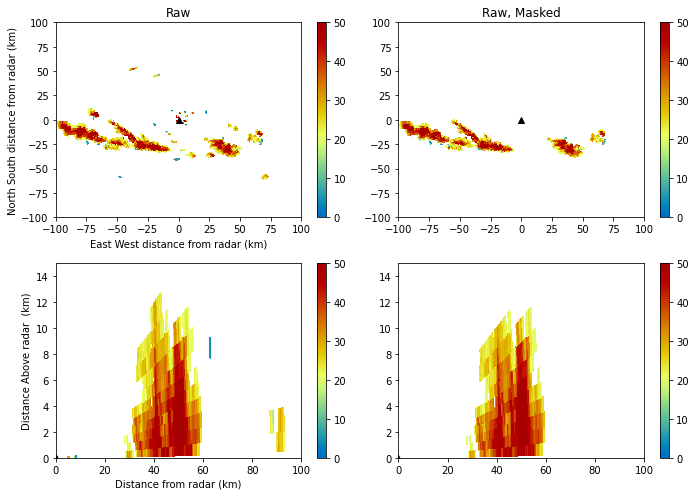

In [3]:
# plot in radar coordinates

gb = ((0,15), (-100,100), (-100,100))
rlim = (0,100)
tilt, ray, vmin, vmax = 0,130, 0, 50

display = pyart.graph.RadarDisplay(radar)
fig = plt.figure(figsize=(10, 7))

ax = fig.add_subplot(221)
ax.plot(0,0, 'k^')
display.plot_ppi(field+'_original', tilt, ax=ax,colorbar_flag= True,
             colorbar_label='',vmin = vmin, vmax = vmax, title=  'Raw',cmap = 'pyart_HomeyerRainbow')
display.set_limits(gb[2], gb[1], ax=ax)

ax = fig.add_subplot(222)
ax.plot(0,0, 'k^')

display.plot_ppi(field+'', tilt, ax=ax,colorbar_flag= True, axislabels_flag = False,
             colorbar_label='',vmin = vmin, vmax = vmax, title=  'Raw, Masked',cmap = 'pyart_HomeyerRainbow')
display.set_limits(gb[2], gb[1], ax=ax)

xsect = pyart.util.cross_section_ppi(radar, [ray])
display = pyart.graph.RadarDisplay(xsect)

ax = fig.add_subplot(223)
ax.plot(0,0, 'k^')

display.plot(field+'_original', 0, colorbar_flag= True, vmin = vmin, vmax = vmax,colorbar_label='',
             title=  '',cmap = 'pyart_HomeyerRainbow')
display.set_limits(rlim, gb[0], ax=ax)
display = pyart.graph.RadarDisplay(xsect)

ax = fig.add_subplot(224)
ax.plot(0,0, 'k^')

display.plot(field+'', 0, colorbar_flag= True, vmin = vmin, vmax = vmax, title=  '',colorbar_label='',
             axislabels_flag = False,cmap = 'pyart_HomeyerRainbow')
display.set_limits(rlim, gb[0], ax=ax)

plt.tight_layout()
plt.show()

In [26]:
import warnings
import multiprocessing as mp

import pyart
import numpy as np
from scipy.spatial import cKDTree
from scipy.signal import savgol_filter
from scipy.interpolate import RegularGridInterpolator
from astropy.convolution import convolve

def get_data_mask(radar, fields, gatefilter=None):
    """
    Create a mask for the gridding algorithm by combining
    all masks from selected radar fields and optionally a
    pyart gatefilter

    Parameters:
    -----------
    radar : (object)
        Pyart radar object
    fields : (list)
        List of fields to accumulate the mask from
    gatefilter : (object)
        A pyart gatefilter
        
    Returns:
    --------
    mask : (np.array)
        Data mask same shape as radar fields, 1 = masked
    """
    
    mask = np.ones((radar.nrays, radar.ngates)).astype('bool')
    
    # combine data masks
    for field in fields:
        mask *= ~radar.fields[field]['data'].mask
        
    # combine gatefilter    
    if gatefilter is not None:
        mask *= ~gatefilter.gate_excluded
    return ~mask

def get_leroy_roi(radar, coords, frac=0.55):
    """
    Get a radius of influence for the ppis based on the azimuthal spacing of each sweep
    
    Refer to Dahl et al (2019) for details here. 
    """
    roi = 0
    rmax = np.sqrt(max(coords[0]) ** 2 + max(coords[1]) ** 2 + max(coords[2]) ** 2)
    for i in range(radar.nsweeps):
        az = np.amax(np.radians(np.amax(np.diff(np.sort(radar.azimuth["data"][radar.get_slice(i)])))))
        r = frac * az * rmax
        if r > roi:
            roi = r
    return roi

def calculate_ppi_heights(radar, coords, Rc, ground_elevation = -9999):
    slices = []
    elevations = radar.fixed_angle["data"]

    Y, X = np.meshgrid(coords[1], coords[2], indexing = 'ij')
    for i in range(radar.nsweeps):
        x, y, z = radar.get_gate_x_y_z(i)
        data = z.ravel()
        tree = cKDTree(np.c_[y.ravel(), x.ravel()])
        d, idx = tree.query(np.c_[Y.ravel(), X.ravel()], k=10, distance_upper_bound=Rc, workers=mp.cpu_count())
        idx[idx == len(data)] = 0

        # do all of the weighting stuff based on kdtree distance
        d[np.isinf(d)] = Rc + 1e3
        d2, r2 = d ** 2, Rc ** 2
        w = (r2 - d2) / (r2 + d2)
        w[w < 0] = 0
        sw = np.sum(w, axis=1)
        valid = sw != 0

        # put valid data into a resultant array and reshape to model grid
        slce = np.zeros(sw.shape)
        if ((i==0) and (elevations[i] <= ground_elevation)):
            pass
        elif len(data) == 0:
            pass
        else:
            slce[valid] = np.sum(data[idx] * w, axis=1)[valid] / sw[valid]
        slce = np.ma.masked_array(slce, mask=~valid)
        slices.append(slce.reshape((len(coords[1]), len(coords[2]))))
        
    return np.ma.asarray(slices)
    

def smooth_grid(grid, coords,kernel,corr_lens,filter_its, verbose):
    
    dz = np.mean(np.diff(np.sort(coords[0])))
    dy = np.mean(np.diff(np.sort(coords[1])))
    dx = np.mean(np.diff(np.sort(coords[2])))
    dh = np.mean((dy, dx))
    
    if verbose:
        print("Filtering...")

    if kernel is None:
        if corr_lens == None:
            raise NotImplementedError(
                """You must either input a convolution kernel 
                ('kernel') or some correlation lengths ('corr_len')."""
            )
        v_window = int(np.ceil(corr_lens[0] / dz) // 2 * 2 + 1)
        h_window = int(np.ceil(corr_lens[1] / dh) // 2 * 2 + 1)
        kernel = np.ones((v_window, h_window, h_window)) / np.float(v_window * h_window * h_window)

    smooth = grid.copy()
    for i in range(filter_its):
        smooth = convolve(smooth, kernel, boundary="extend")

    return smooth.copy()




def setup_interpolate(radar, coords, dmask, Rc, k=200, verbose = True):
    """
    A function for interpolating radar fields to ppi surfaces in 
    Cartesian coordinates. 
    
    Inputs:
    radar (Pyart object): radar to be interpolated
    coords (tuple): tuple of 3 1d arrays containing z, y, x of grid
    Rc (float): Cressman radius of interpolation
    field (string): field name in radar or 'height' for altitude
    k (int): max number of points within a radius of influence
    """
    t0 = time.time()
    # setup stuff
    nsweeps = radar.nsweeps
    weights, idxs = [], []
    elevations = radar.fixed_angle["data"]
    Y, X = np.meshgrid(coords[1], coords[2], indexing="ij")
    trim = 0
    model_idxs = -np.ones((nsweeps, len(coords[1])*len(coords[2])))
    sws, model_lens = [], []
    # loop through grid and define data, no mask for height data
    for i in range(nsweeps):
        x, y, z = radar.get_gate_x_y_z(i)
        mask = ~dmask[radar.get_slice(i)].flatten()

        # dont bother with ckdtree if there's no data
        if mask.sum() == 0:
            weights.append(np.empty((1,1)))
            idxs.append(np.empty((1,1)))
            sws.append(np.zeros(len(coords[1])*len(coords[2])))
            model_lens.append(0)
            continue
            
        # define a lookup tree for the horizontal coordinates
        valid_radar_points = np.c_[y.ravel()[mask], x.ravel()[mask]]
        ndata = valid_radar_points.shape[0]
        tree = cKDTree(valid_radar_points)
        d, idx = tree.query(np.c_[Y.ravel(), X.ravel()], k=k, distance_upper_bound=Rc, workers=mp.cpu_count())
        
        # check if any kth weight is valid, and trim if possible
        valid = ~(idx == ndata)
        kidx = max(np.where(valid==1)[1])+1
        
        if valid[:,-1].sum() > 0:
            warnings.warn("\n Some points are being left out of radius of influence, make 'k' bigger!")
        
        # set invalid indicies to 0 to avoid errors, they are masked out by the weights anyway
        idx[idx == ndata] = 0

        # do all of the weighting stuff based on kdtree distance
        d[np.isinf(d)] = Rc + 1e3
        d2, r2 = d ** 2, Rc ** 2
        w = (r2 - d2) / (r2 + d2)
        w[w < 0] = 0
        sw = np.sum(w, axis=1)
        model_idx = np.where(sw!=0)[0]
        model_idxs[i][:len(model_idx)] = model_idx
        model_lens.append(len(model_idx))
        sws.append(sw)
        weights.append(w[model_idx,:kidx])
        idxs.append(idx[model_idx,:kidx])

    
    # stack weights 
    return weights, idxs, model_idxs[:,:max(model_lens)].astype(int), np.array(sws), model_lens

def cressman_ppi_interp(radar, coords, field_names, gatefilter = None, Rc=None, k=100, 
                        filter_its=0, verbose=True, kernel=None, corr_lens=None, ground_elevation = -999):
    """
    Interpolate multiple fields from a radar object to a grid. This 
    is an implementation of the method described in Dahl et. al. (2019).
    
    Inputs:
    radar (Pyart object): radar to be interpolated
    coords (tuple): tuple of 3 1d arrays containing z, y, x of grid
    field_names (list or string): field names in radar to interpolate
    Rc (float): Cressman radius of interpolation, calculated if not supplied
    k (int): max number of points within a radius of influence
    filter_its (int): number of filter iterations for the low-pass filter
    kernel (astropy.kernel): user defined kernel for smoothing (boxcar filter if not specified)
    corr_lens (tuple): correlation lengths for smoothing filter in vert. and horiz. dims resp.
    
    """
    t0 = time.time()

    if type(field_names) != list:
        field_names = [field_names,]

    fields = []
    dims = [len(coord) for coord in coords]

    if Rc is None:
        Rc = get_leroy_roi(radar, coords, frac=0.55)
        if verbose:
            print("Radius of influence set to {} m.".format(Rc))
            
    dmask = get_data_mask(radar, field_names)
    Rc = get_leroy_roi(radar, coords, frac=0.55)
    weights, idxs, model_idxs, sw, model_lens = setup_interpolate(radar, coords, dmask, Rc, k=200)            
    Z, Y, X = np.meshgrid(coords[0], coords[1], coords[2], indexing="ij")
    ppi_height = calculate_ppi_heights(radar, coords, Rc, ground_elevation = ground_elevation)
    
    if ppi_height.mask.sum() > 0:
        warnings.warn("""\n There are invalid height values which will 
        ruin the linear interpolation. This most likely means the radar
        doesnt cover the entire gridded domain""")

    
    for field in field_names:
        ppis  = np.zeros((radar.nsweeps, dims[1]*dims[2]))
        mask  = np.ones((radar.nsweeps, dims[1]*dims[2]))
        for i in range(radar.nsweeps):
            slc = radar.get_slice(i)
            data = radar.fields[field]['data'].filled(0)[slc][~dmask[slc]]
            if len(data) > 0:
                ppis[i, model_idxs[i, :model_lens[i]]] = np.sum(data[idxs[i]] * weights[i], axis=1)/ sw[i, model_idxs[i, :model_lens[i]]]
                mask[i, model_idxs[i, :model_lens[i]]] = 0
                out = np.ma.masked_array(ppis.reshape((radar.nsweeps, dims[1], dims[2])), mask.reshape((radar.nsweeps, dims[1], dims[2])))
                
        grid = leroi.leroi.interp_along_axis(out.filled(np.nan), ppi_height, Z, axis=0, method="linear")

        if filter_its > 0:
                grid = smooth_grid(grid, coords,kernel,corr_lens,filter_its, verbose)
    
        fields.append(np.ma.masked_array(grid, mask=np.isnan(grid)))
        
    if verbose:
        print('Took: ', time.time()-t0)
        
    if len(fields) > 1:
        return fields
    else:
        return fields[0]
    
    return fields
    
grid = cressman_ppi_interp(radar, coords, [field, 'corrected_velocity', 'corrected_differential_reflectivity'], k=200, 
                           ground_elevation = 0.5, filter_its = 0, corr_lens= (500,2000)) 
             

Radius of influence set to 3579.366975146072 m.


/home/564/jb2354/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:227: UserWarning: 
 There are invalid height values which will 
        ruin the linear interpolation. This most likely means the radar
        doesnt cover the entire gridded domain
/home/564/jb2354/miniconda3/lib/python3.7/site-packages/leroi-0.0.1-py3.7.egg/leroi/leroi.py:205: UserWarning: Some values are outside the interpolation range. These will be filled with NaN
/home/564/jb2354/miniconda3/lib/python3.7/site-packages/leroi-0.0.1-py3.7.egg/leroi/leroi.py:246: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/home/564/jb2354/miniconda3/lib/python3.7/site-packages/numpy/ma/core.py:3225: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tupl

Took:  7.584789276123047


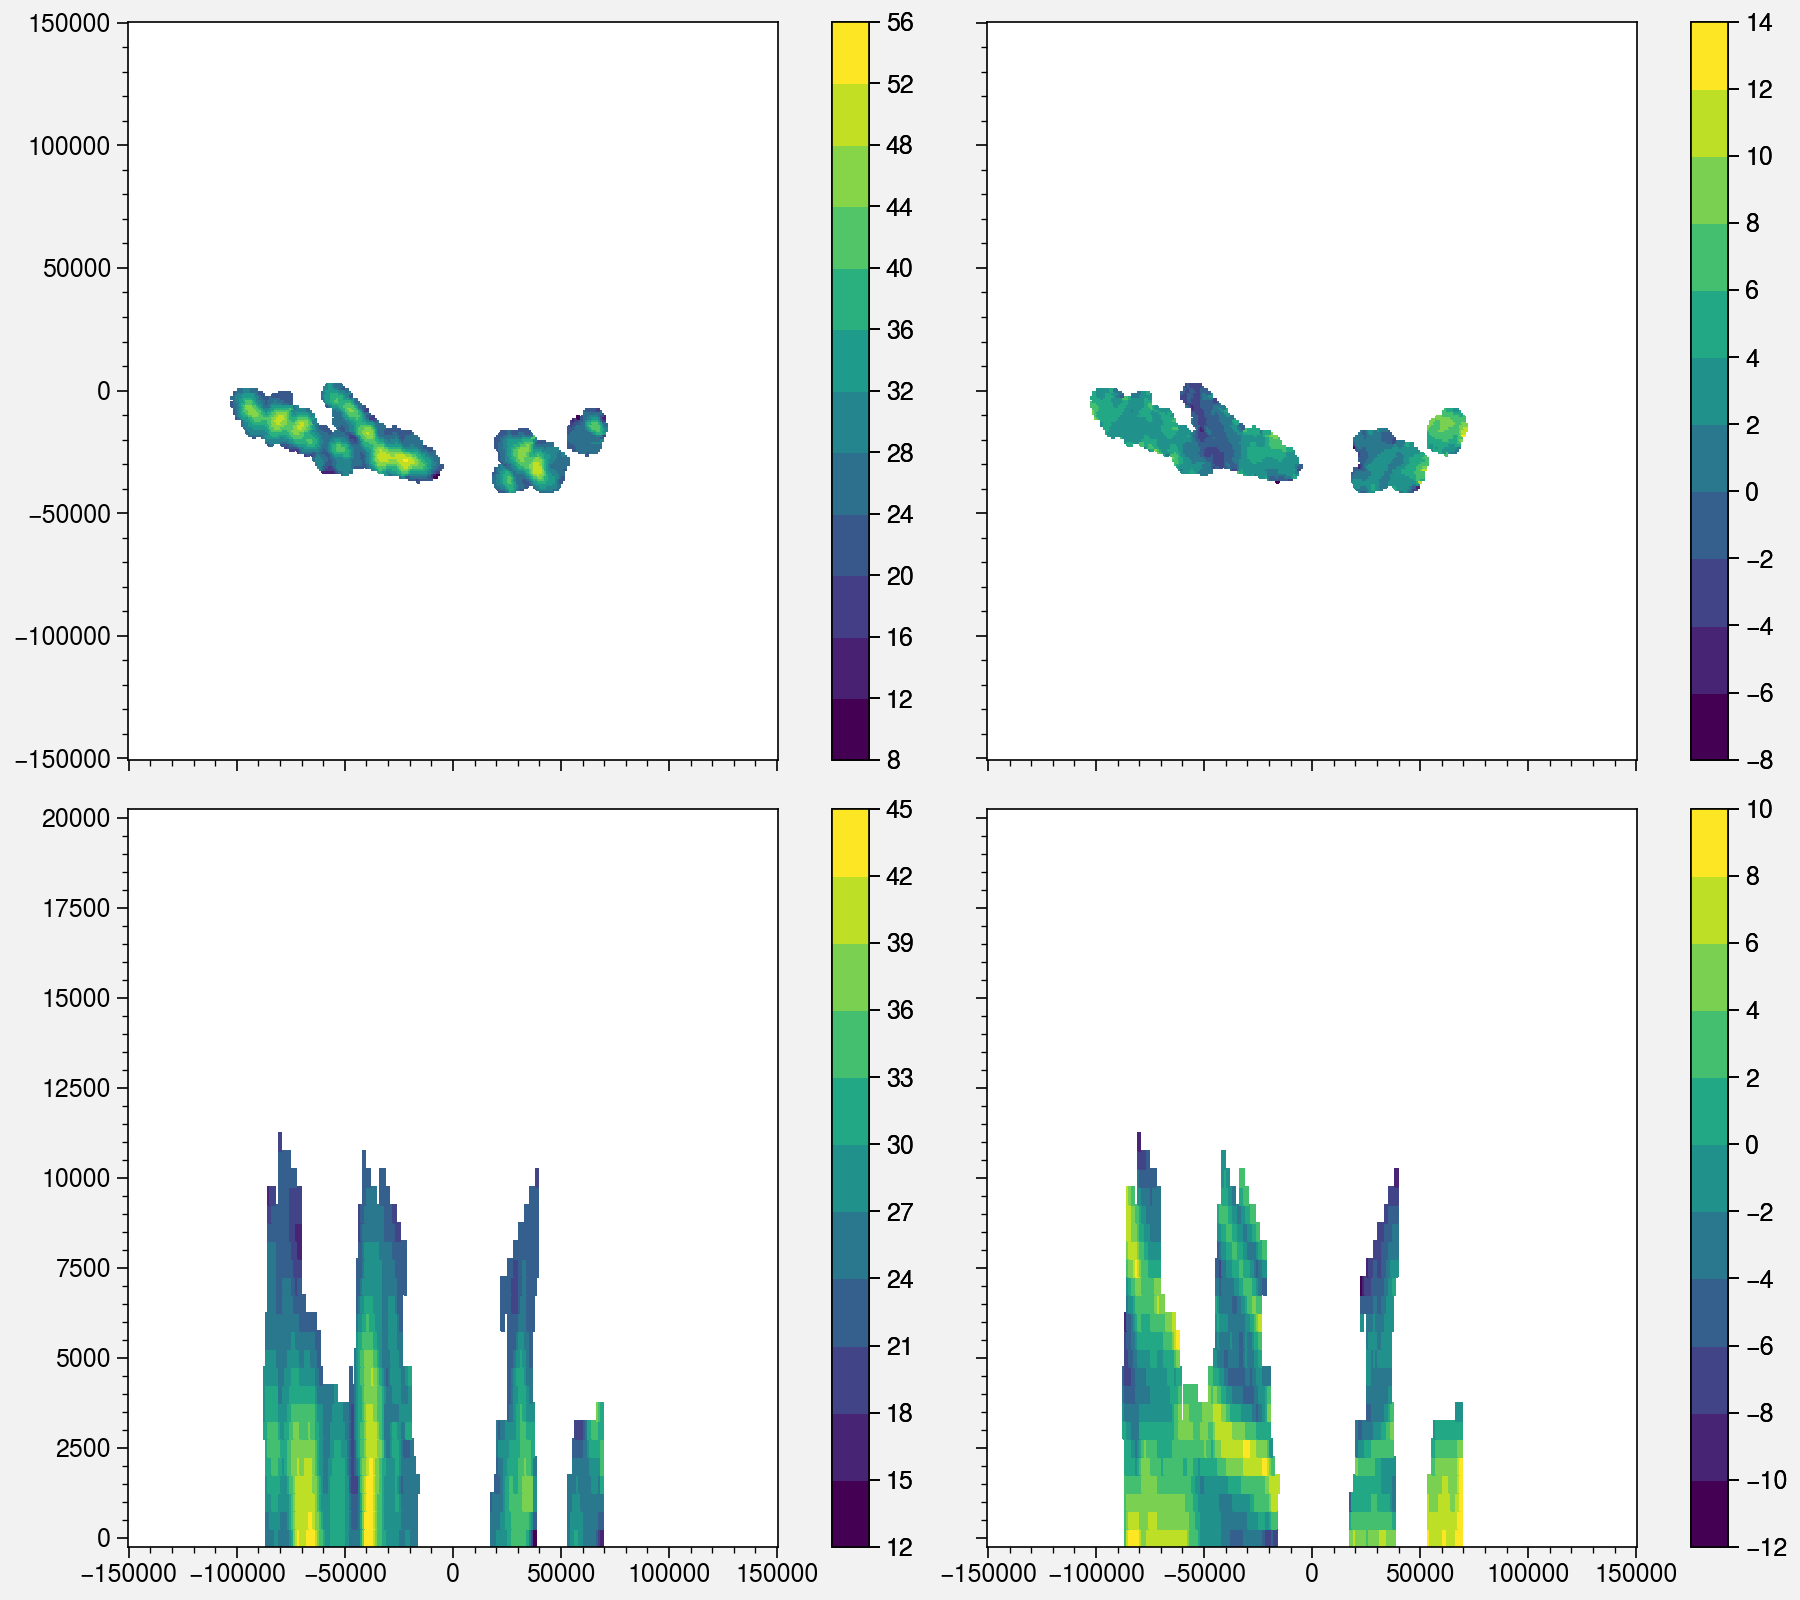

In [15]:
import proplot as plot
zidx = 3
fig, axs = plot.subplots(nrows = 2, ncols = 2, figsize = (9,8))
for i in range(2):
    axs[i].pcolormesh(coords[2], coords[1], grid[i][zidx, ...], cmap = 'viridis', colorbar = 'r')
    axs[i+2].pcolormesh(coords[2], coords[0], grid[i][:, 130,:], cmap = 'viridis', colorbar = 'r')
plot.show()

# Gridding

In [24]:
gs = (41, 301, 301)
gb = ((1, 20001), (-150000,150000),(-150000,150000))
center_pos = (0,0,0)
lon0, lat0 = radar.longitude['data'][0], radar.latitude['data'][0]

x = np.linspace(gb[2][0],gb[2][1], gs[2])
y = np.linspace(gb[1][0],gb[1][1], gs[1])
z = np.linspace(gb[0][0],gb[0][1], gs[0])
coords = (z-center_pos[0], y-center_pos[1], x-center_pos[2])

def leroi_grid(radar,coords, fields):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        return cressman_ppi_interp(radar, coords, fields, Rc=3500, k=200, verbose=False, filter_its = 0, corr_lens = (800, 2000))
def const_cressman(radar, fields):
    grid = pyart.map.grid_from_radars((radar,), grid_origin = (lat0, lon0), grid_shape=gs, roi_func = 'constant', constant_roi = 3500,
                                      weighting_function = 'Cressman',grid_limits=gb, fields=fields)
    return grid.fields[field]['data']

In [25]:
fields = ['corrected_reflectivity', 'corrected_velocity', 'corrected_differential_reflectivity']
start = time.time()
f_leroi = leroi_grid(radar,coords, fields)
end = time.time()
print('leroi', end-start)
start = time.time()
f_const = const_cressman(radar, fields)
end = time.time()
print('pyart', end-start)

leroi 7.441983938217163
pyart 4.165144443511963


/home/564/jb2354/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  after removing the cwd from sys.path.
/home/564/jb2354/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  if __name__ == '__main__':


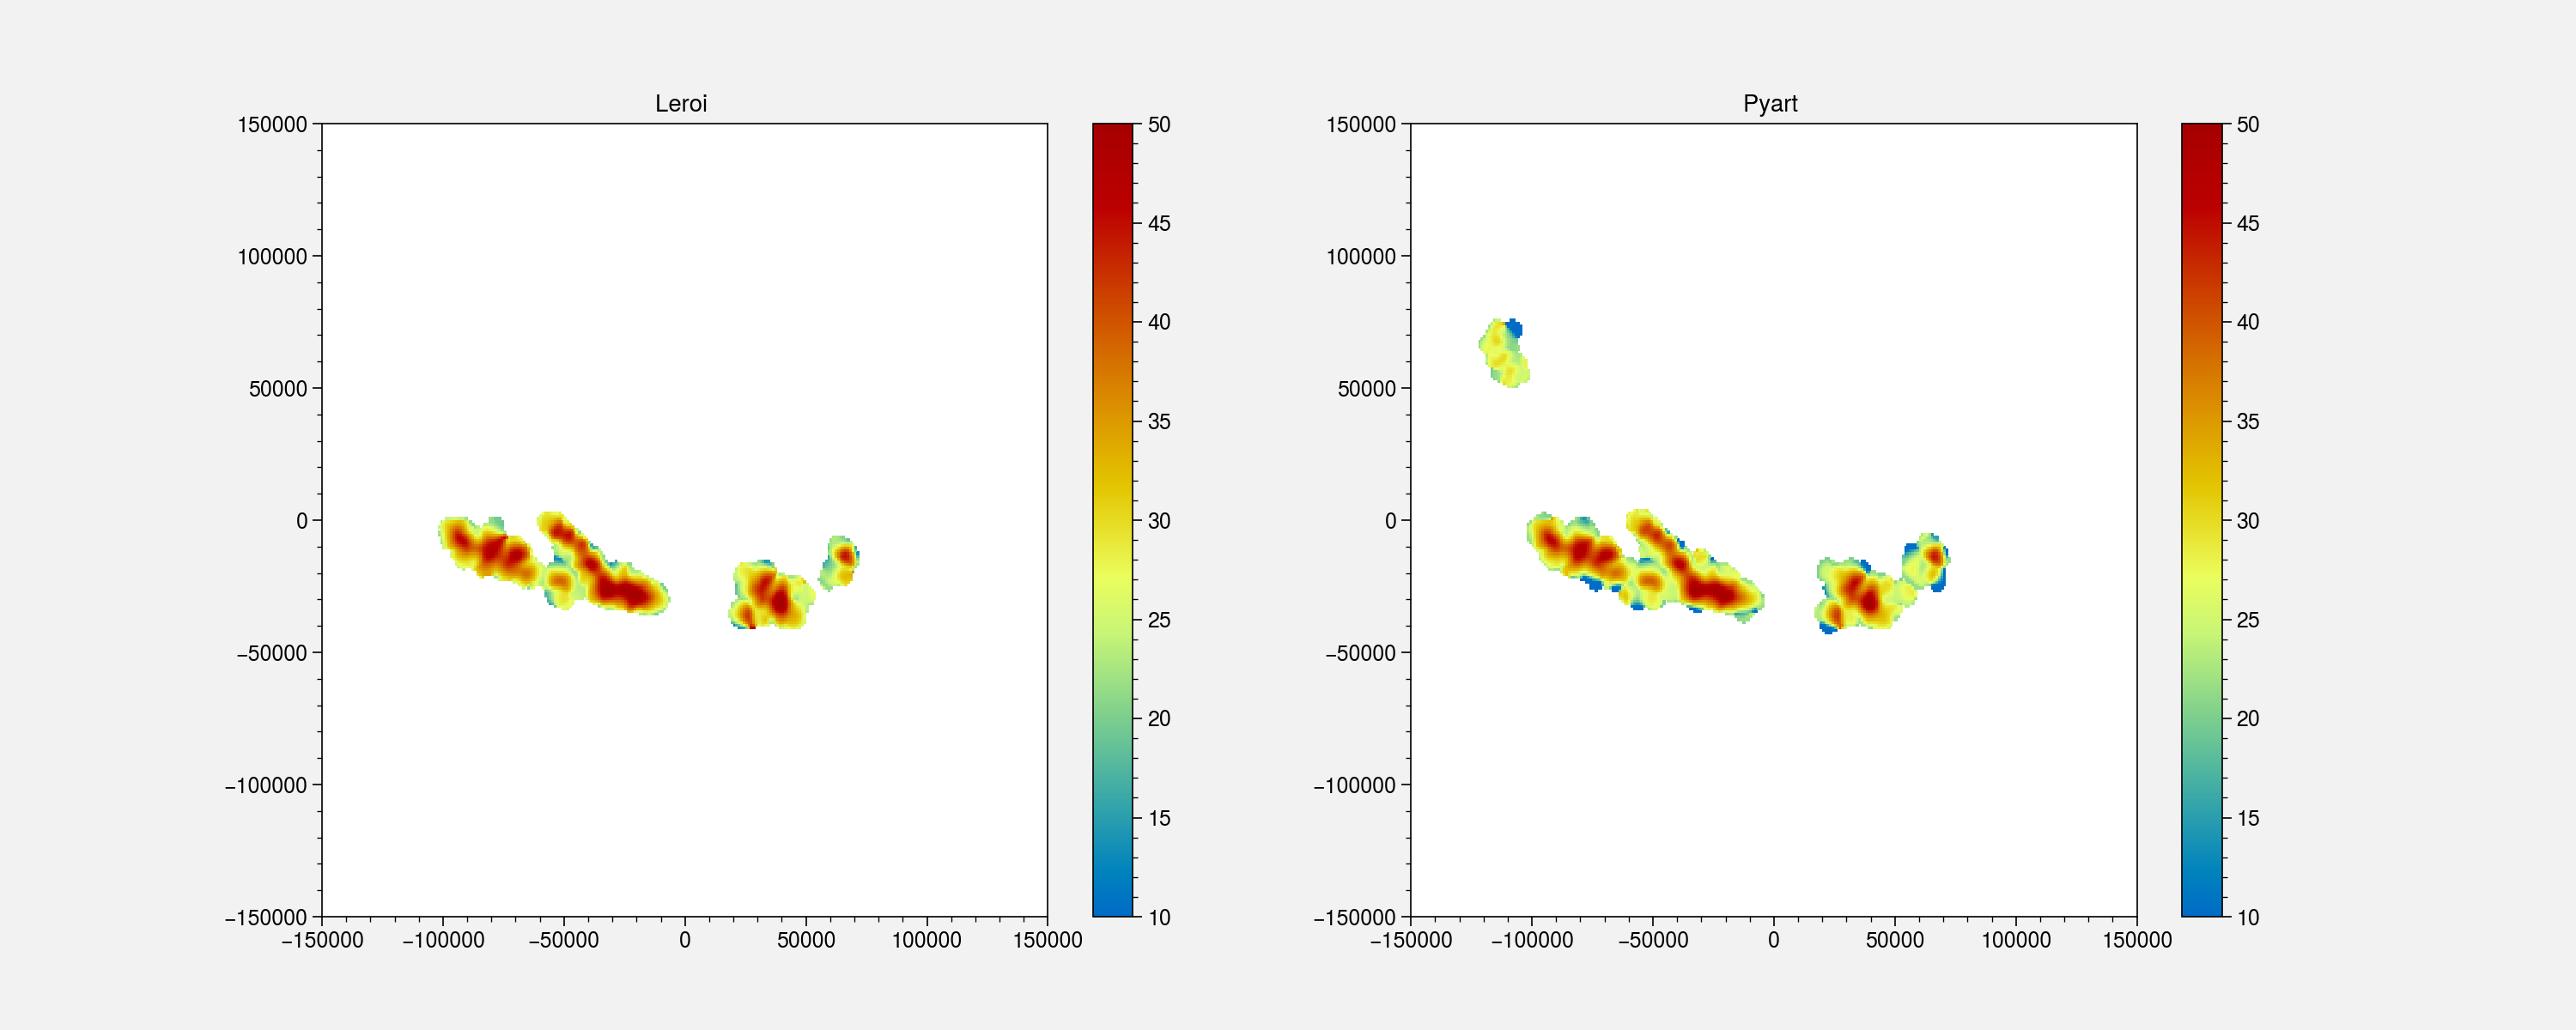

In [20]:
zidx = 5
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(121)
m = ax.pcolormesh(x,y,f_leroi[zidx,...], cmap ='pyart_HomeyerRainbow', vmin = 10, vmax = 50)
plt.colorbar(m)
ax.set_title('Leroi ')

ax = fig.add_subplot(122)
m = ax.pcolormesh(x,y,f_const[zidx,...], cmap ='pyart_HomeyerRainbow', vmin = 10, vmax = 50)
plt.colorbar(m)
ax.set_title('Pyart ')
plt.show()

/g/data/en0/jss548/miniconda3/envs/radar-dev/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-79-577a8184124e>:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  m = ax.pcolormesh(x,z,f_leroy[:,yidx,:], cmap ='pyart_HomeyerRainbow', vmin = 0, vmax = 50)
<ipython-input-79-577a8184124e>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the co

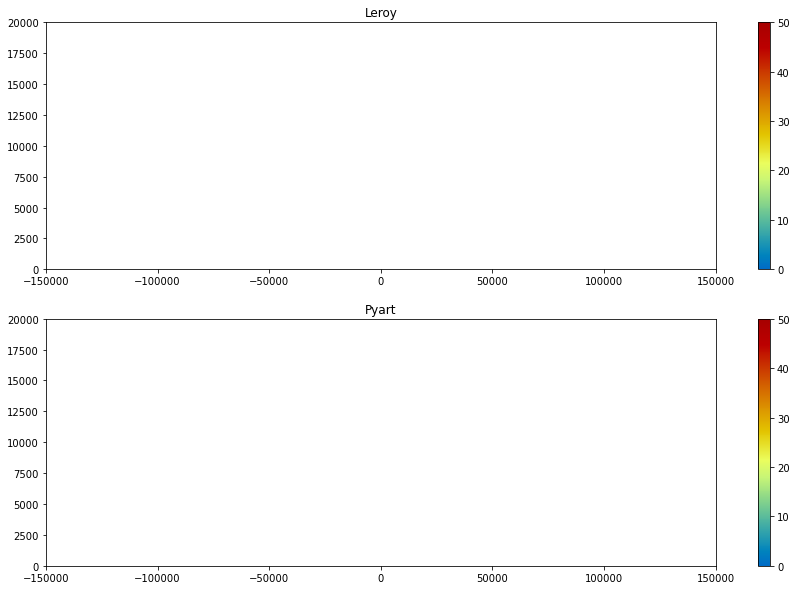

In [79]:
yidx = 70
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(211)
m = ax.pcolormesh(x,z,f_leroy[:,yidx,:], cmap ='pyart_HomeyerRainbow', vmin = 0, vmax = 50)
plt.colorbar(m)
ax.set_title('Leroy')
ax = fig.add_subplot(212)
m = ax.pcolormesh(x,z,f_const[:,yidx,:], cmap ='pyart_HomeyerRainbow', vmin = 0, vmax = 50)
plt.colorbar(m)
ax.set_title('Pyart')

plt.show()

### testing weights function

Radius of influence set to 3579.365398294048 m.
Took 4.0717527866363525 seconds.
Took:  0.198744535446167
(0,)


Took 3.616888999938965 seconds.


In [340]:
radar.fields.keys()

dict_keys(['radar_echo_classification', 'radar_estimated_rain_rate', 'velocity', 'corrected_velocity', 'total_power', 'corrected_reflectivity', 'cross_correlation_ratio', 'differential_reflectivity', 'corrected_differential_reflectivity', 'differential_phase', 'corrected_differential_phase', 'corrected_specific_differential_phase', 'spectrum_width', 'signal_to_noise_ratio', 'corrected_reflectivity_original'])

### making the masking function

In [54]:
import proplot as plot



gatefilter = pyart.correct.GateFilter(radar)
gatefilter.exclude_below(field, 40)

mask1 = get_data_mask(radar, [field+'_original'])
mask2 = get_data_mask(radar, [field,])
mask3 = get_data_mask(radar, [field+'_original', field])
mask4 = get_data_mask(radar, [field+'_original', field], gatefilter=gatefilter)

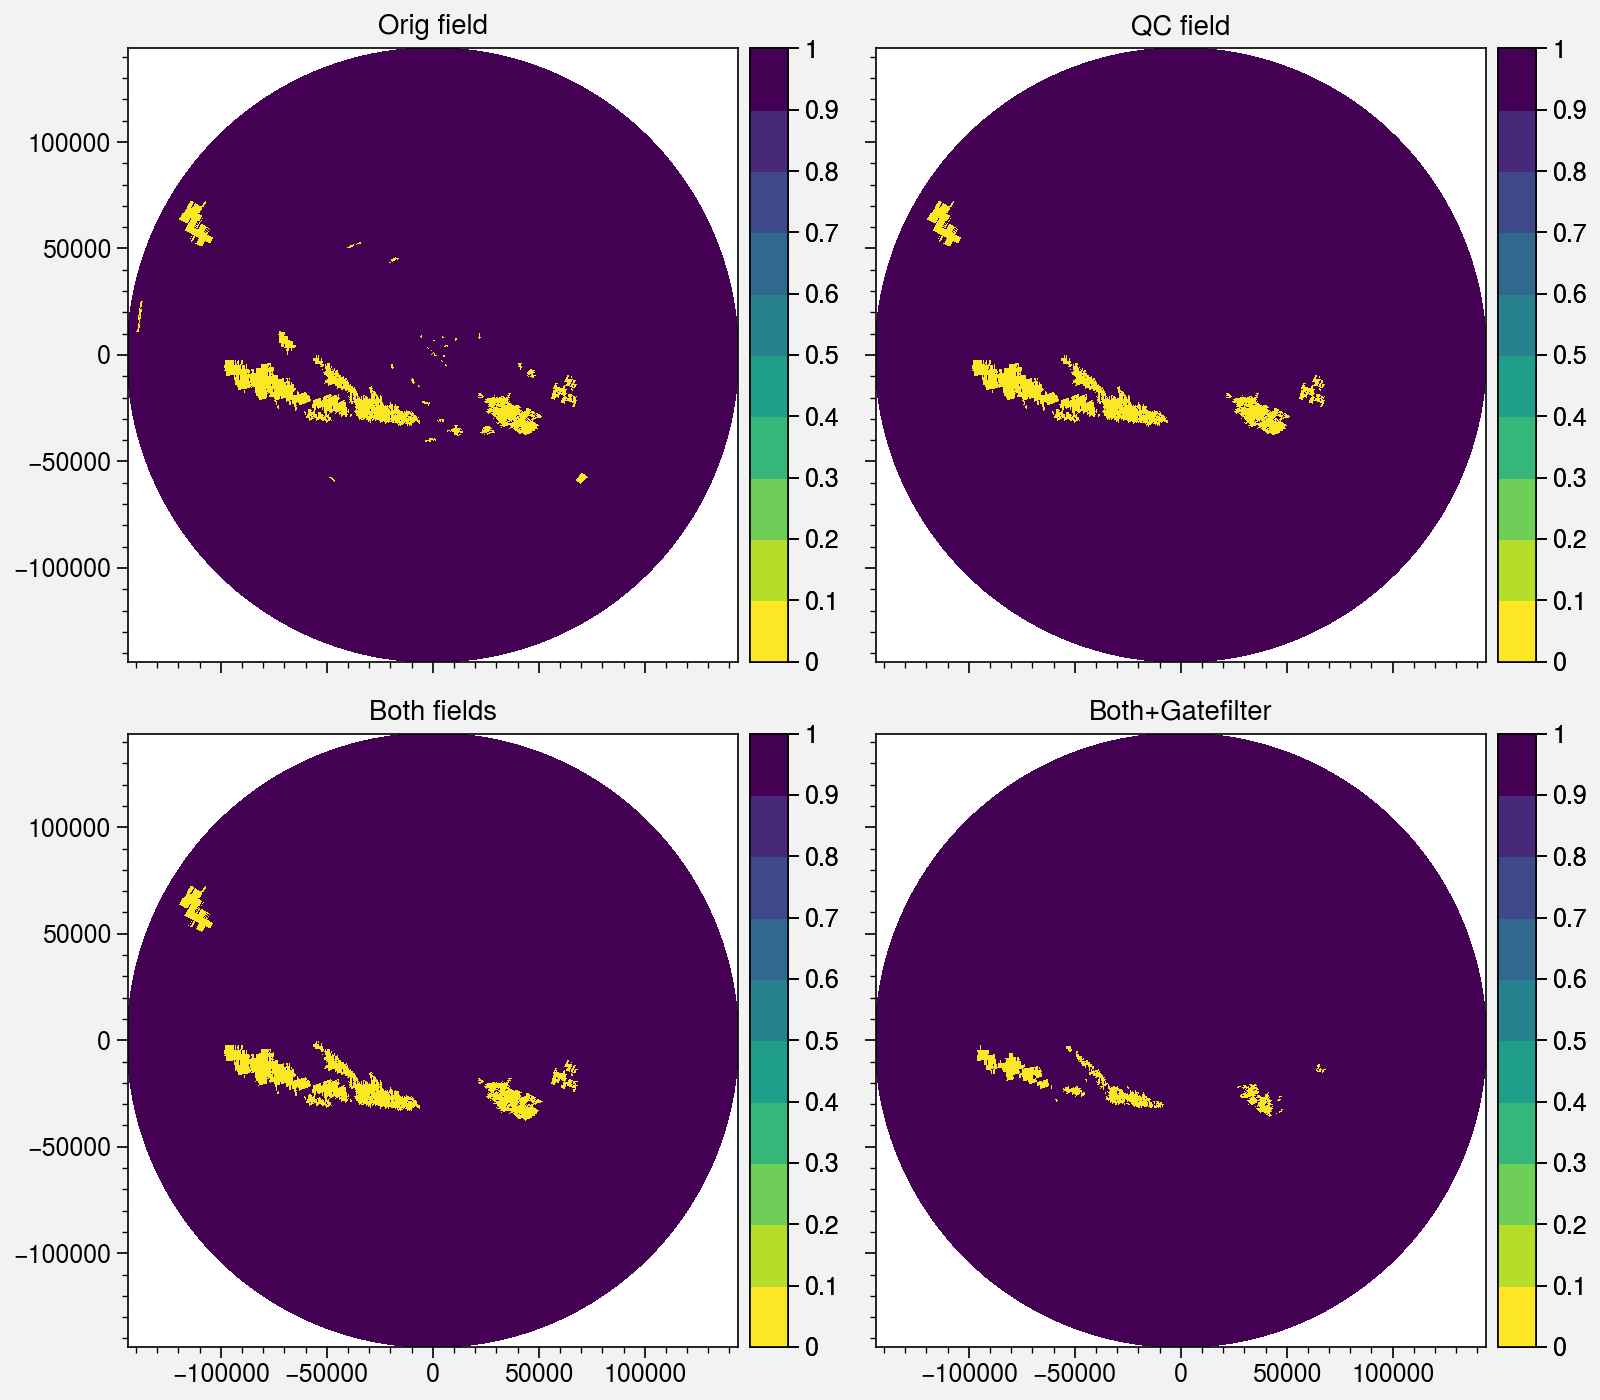

In [57]:
tilt = 0
x, y, z = radar.get_gate_x_y_z(tilt)
tslice = radar.get_slice(tilt)
fields = [mask1[tslice], mask2[tslice], mask3[tslice], mask4[tslice]]
titles = ['Orig field','QC field', 'Both fields', 'Both+Gatefilter']
fig, axs = plot.subplots(nrows = 2, ncols = 2, figsize = (8,7))
for i, ax in enumerate(axs):
    ax.pcolormesh(x, y, fields[i], cmap = 'viridis_r', colorbar = 'r')
    ax.format(title = titles[i])
plot.show()

masked_array(
  data=[[5.1000e+01, 5.3000e+01, 5.5000e+01, ..., 2.2730e+03, 2.2800e+03,
         2.2870e+03],
        [5.1000e+01, 5.3000e+01, 5.4000e+01, ..., 2.2340e+03, 2.2410e+03,
         2.2480e+03],
        [5.1000e+01, 5.3000e+01, 5.4000e+01, ..., 2.1560e+03, 2.1630e+03,
         2.1690e+03],
        ...,
        [1.5000e+02, 3.5200e+02, 5.5300e+02, ..., 9.6849e+04, 9.7053e+04,
         9.7257e+04],
        [1.5000e+02, 3.5200e+02, 5.5300e+02, ..., 9.6849e+04, 9.7053e+04,
         9.7257e+04],
        [1.5000e+02, 3.5200e+02, 5.5300e+02, ..., 9.6849e+04, 9.7053e+04,
         9.7257e+04]],
  mask=False,
  fill_value=1e+20)

In [387]:
t0 = time.time()
def calculate_ppi_heights(radar, coords, Rc, ground_elevation = -9999):
    slices = []
    elevations = radar.fixed_angle["data"]
    print(elevations)

    Y, X = np.meshgrid(coords[1], coords[2], indexing = 'ij')
    for i in range(radar.nsweeps):
        x, y, z = radar.get_gate_x_y_z(i)
        data = z.ravel()
        tree = cKDTree(np.c_[y.ravel(), x.ravel()])
        d, idx = tree.query(np.c_[Y.ravel(), X.ravel()], k=10, distance_upper_bound=Rc, workers=mp.cpu_count())
        idx[idx == len(data)] = 0

        # do all of the weighting stuff based on kdtree distance
        d[np.isinf(d)] = Rc + 1e3
        d2, r2 = d ** 2, Rc ** 2
        w = (r2 - d2) / (r2 + d2)
        w[w < 0] = 0
        sw = np.sum(w, axis=1)
        valid = sw != 0

        # put valid data into a resultant array and reshape to model grid
        slce = np.zeros(sw.shape)
        if ((i==0) and (elevations[i] <= ground_elevation)):
            pass
        elif len(data) == 0:
            pass
        else:
            slce[valid] = np.sum(data[idx] * w, axis=1)[valid] / sw[valid]
        slce = np.ma.masked_array(slce, mask=~valid)
        slices.append(slce.reshape((len(coords[1]), len(coords[2]))))
        
    return np.ma.asarray(slices)
    
heights = calculate_ppi_heights(radar, coords, 2500, ground_elevation = 1.6)
print(time.time()-t0)
        

[ 0.5       1.59375   2.78125   3.875     5.        6.1875    7.484375
  9.09375  11.       13.       15.       17.984375 21.59375  25.59375
 30.296875 35.78125  42.203125]
1.2971696853637695


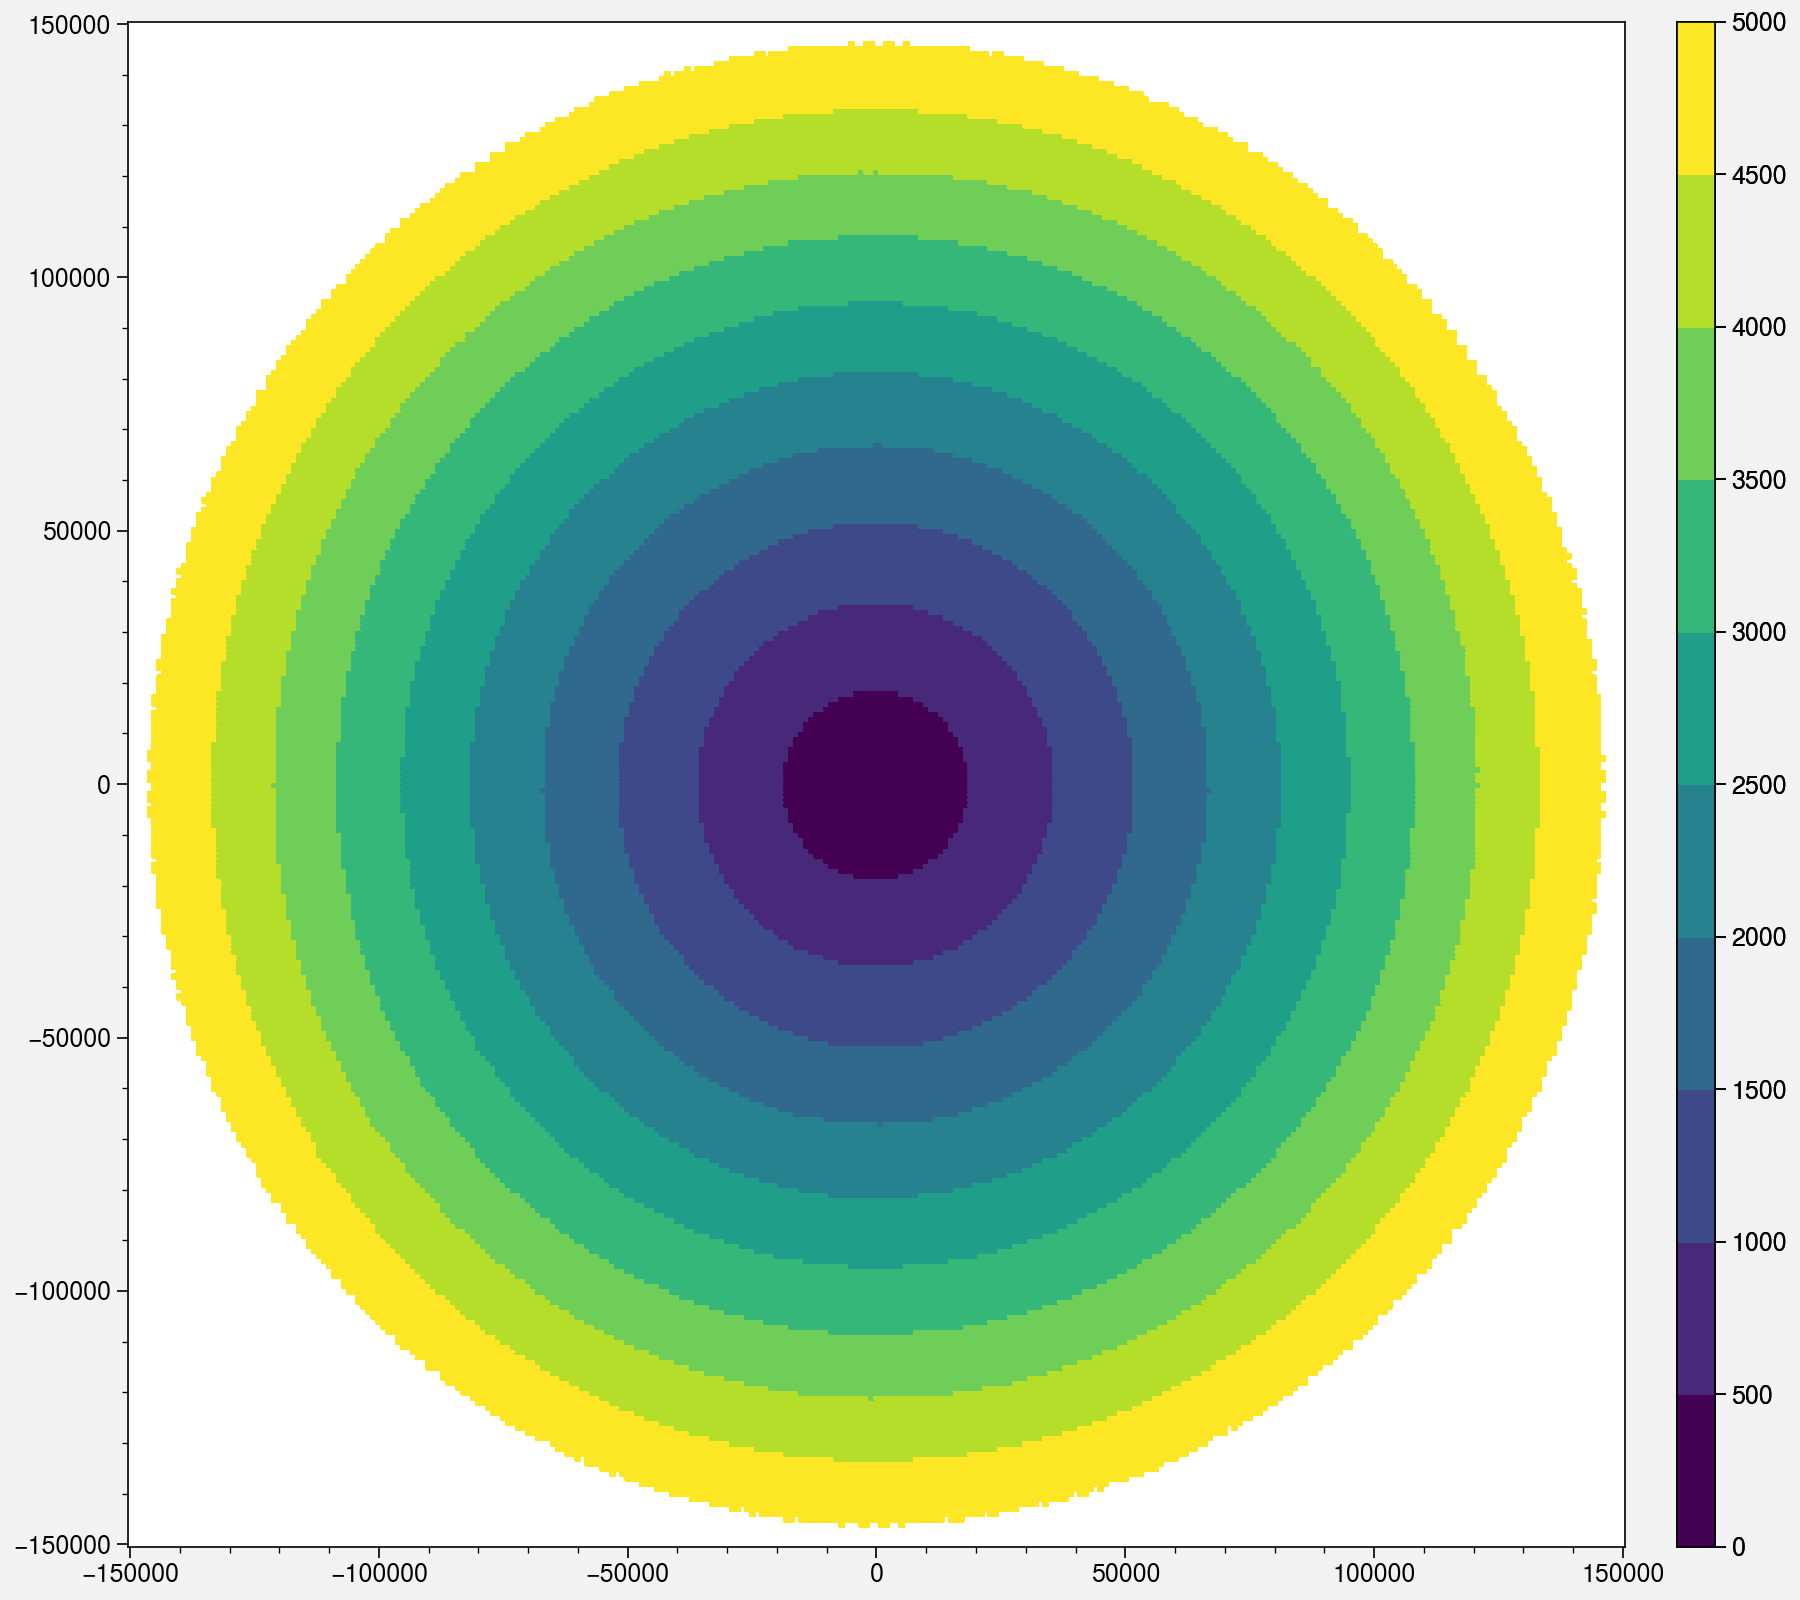

In [390]:
zidx = 1
fig, axs = plot.subplots(figsize = (9,8))
for i, ax in enumerate(axs):
    ax.pcolormesh(coords[2], coords[1], heights[zidx, ...], cmap = 'viridis', colorbar = 'r')
plot.show()